In [1]:
!pip install scikit-optimize
import tensorflow as tf
import datetime
from tensorflow.keras import datasets, layers, models
from keras.callbacks import TensorBoard
from tensorflow.keras.layers import *
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from skopt.space import Real, Integer, Categorical
from skopt import gp_minimize
from skopt.utils import use_named_args
from tensorflow.python.keras.callbacks import EarlyStopping
from skopt import callbacks
from skopt.callbacks import CheckpointSaver
from tensorflow.keras.optimizers import *
import gc


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
assert train_images.shape == (50000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)
assert train_labels.shape == (50000, 1)
assert test_labels.shape == (10000, 1)

170498071/170498071 [==============================] - 14s 0us/step


In [3]:
x_train = train_images.astype('float32') / 255.
x_test = test_images.astype('float32') / 255.
y_train = keras.utils.to_categorical(train_labels, 10)
y_test = keras.utils.to_categorical(test_labels, 10)

In [4]:
datagen = ImageDataGenerator()
datagen.fit(x_train)

In [5]:
x_test.shape

(10000, 32, 32, 3)

In [6]:
train_images.shape

(50000, 32, 32, 3)

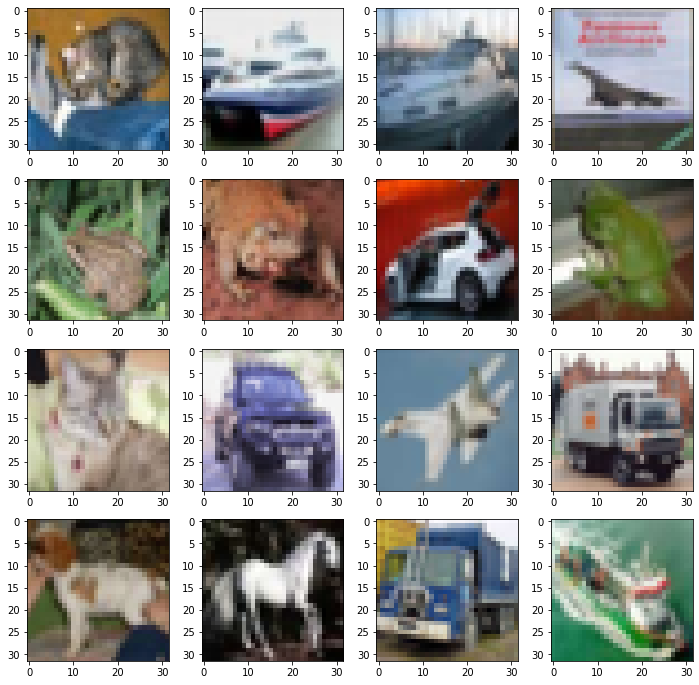

In [7]:
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(test_images[0:16], axs):
    ax.imshow(img)

# Autoencoder

In [8]:
def autoencoder(optimizer):
    model = models.Sequential()
    model.add(Input(shape= (32,32,3)))
    model.add(Conv2D(32, (3,3), padding="same", strides = 1, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", strides = 1, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", strides = 1, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Reshape(target_shape=(4, 4, 32)))
    model.add(Conv2DTranspose(8, (3,3), padding="same", strides = (2,2),activation='relu'))
    model.add(Conv2DTranspose(8, (3,3), padding="same", strides = (2,2),activation='relu')) 
    model.add(Conv2DTranspose(8, (3,3), padding="same", strides = (2,2),activation='relu')) 
    model.add(Conv2D(3, (3, 3), activation="sigmoid", padding="same"))
    model.compile(loss = 'mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    return model

In [9]:
keras.backend.clear_session()
model = autoencoder('SGD')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [10]:
log_dir = "Tensor_board/04_ev/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir='log_dir',
    histogram_freq=1,
    write_graph=True,
    write_grads=False,
    write_images=False)

history = model.fit_generator(datagen.flow(x_train, x_train, batch_size=1024),
                    epochs=100,
                    validation_data = (x_test, x_test),
                    shuffle=True,
                    callbacks=[tensorboard_callback])

<ipython-input-10-4d41672db274>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, x_train, batch_size=1024),


Epoch 1/100
49/49 [==============================] - 14s 110ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 0.0636 - val_mean_squared_error: 0.0636
Epoch 2/100
49/49 [==============================] - 5s 94ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 0.0635 - val_mean_squared_error: 0.0635
Epoch 3/100
49/49 [==============================] - 5s 93ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0635 - val_mean_squared_error: 0.0635
Epoch 4/100
49/49 [==============================] - 5s 93ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0634 - val_mean_squared_error: 0.0634
Epoch 5/100
49/49 [==============================] - 5s 94ms/step - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0634 - val_mean_squared_error: 0.0634
Epoch 6/100
49/49 [==============================] - 5s 93ms/step - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0633 - val_mean_squared_error: 0.0633
Epoch 7/100
49/49 [=======

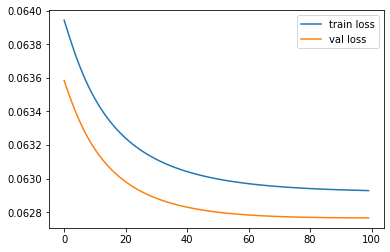

In [11]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

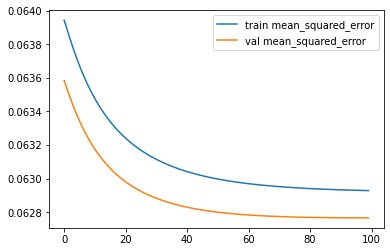

In [12]:
plt.plot(history.history['mean_squared_error'], label='train mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val mean_squared_error')
plt.legend()
plt.show()

In [13]:
decoded_imgs = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


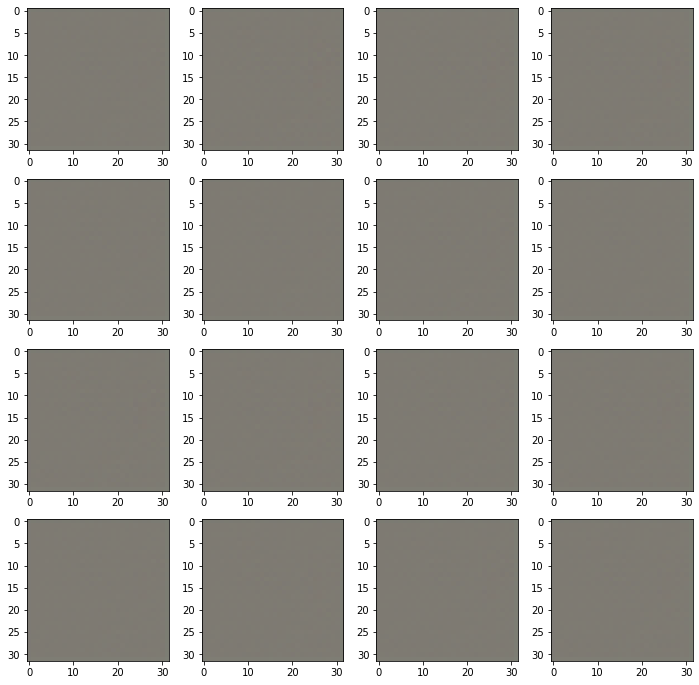

In [14]:
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(decoded_imgs[0:16], axs):
    ax.imshow(img)

## Comment

### Zadany w zadaniu opimalizer nie pozwolił uzykać oczykiwanego efektu działania autoencodera. Poniżej działanie encodera przy wykorzystaniu optimizera "Adam"

In [15]:
keras.backend.clear_session()
model = autoencoder('Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [22]:
log_dir = "Tensor_board/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir='log_dir',
    histogram_freq=1,
    write_graph=True,
    write_grads=False,
    write_images=False)

history = model.fit_generator(datagen.flow(x_train, x_train, batch_size=1024),
                    epochs=100,
                    validation_data = (x_test, x_test),
                    shuffle=True,
                    callbacks=[tensorboard_callback])

<ipython-input-22-17478f40e945>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, x_train, batch_size=1024),


Epoch 1/100
49/49 [==============================] - 7s 141ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 2/100
49/49 [==============================] - 4s 84ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 3/100
49/49 [==============================] - 5s 94ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 4/100
49/49 [==============================] - 4s 85ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 5/100
49/49 [==============================] - 5s 94ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 6/100
49/49 [==============================] - 4s 85ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 7/100
49/49 [========

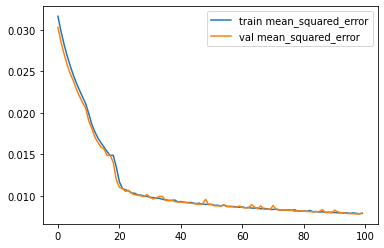

In [23]:
plt.plot(history.history['mean_squared_error'], label='train mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val mean_squared_error')
plt.legend()
plt.show()

In [24]:
decoded_imgs = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [25]:
decoded_imgs[0]

array([[[0.5140544 , 0.43055823, 0.2972795 ],
        [0.5463704 , 0.42470998, 0.26876512],
        [0.5305405 , 0.41791895, 0.2594311 ],
        ...,
        [0.52752507, 0.37973806, 0.2066484 ],
        [0.5084741 , 0.36519685, 0.1921861 ],
        [0.4396738 , 0.35795823, 0.23786044]],

       [[0.5522078 , 0.44536346, 0.28152388],
        [0.5931352 , 0.4308722 , 0.21757257],
        [0.5842012 , 0.42036748, 0.20512113],
        ...,
        [0.56268376, 0.37630764, 0.16081908],
        [0.5423364 , 0.3540217 , 0.1493706 ],
        [0.48609063, 0.36350298, 0.19948497]],

       [[0.5609984 , 0.45498157, 0.29175162],
        [0.60749304, 0.43527272, 0.22068009],
        [0.62998354, 0.45103526, 0.21607131],
        ...,
        [0.55197936, 0.374061  , 0.16474706],
        [0.5397008 , 0.35263753, 0.15694909],
        [0.4932767 , 0.38369182, 0.20433773]],

       ...,

       [[0.2904715 , 0.44814315, 0.59033644],
        [0.18911742, 0.3551916 , 0.5382285 ],
        [0.15629177, 0

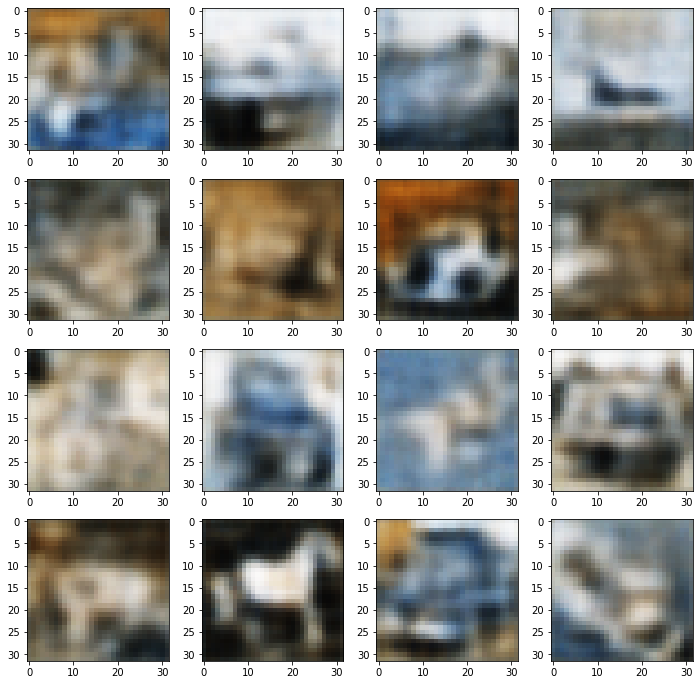

In [26]:
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(decoded_imgs[0:16], axs):
    ax.imshow(img)

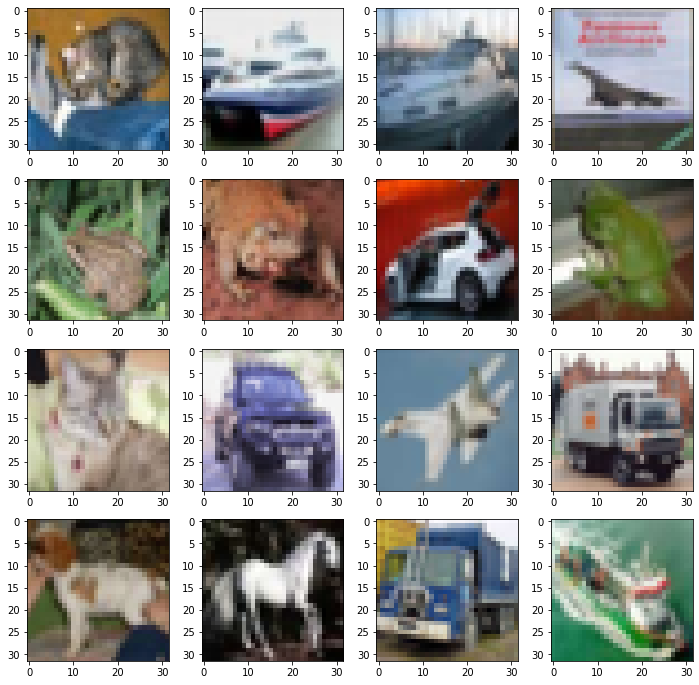

In [27]:
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(x_test[0:16], axs):
    ax.imshow(img)

 ## Comment
 ### Przez wszystkie epoki odbywał się proces uczenia, nie wystąpiło zjawisko overfittingu ani underfittingu, błąd średniokwadratowy dla zbioru uczącego i walidaccyjnego cały czas obniżał się. Udało się uzyskać oczekiwany wynik, zrekonstruowane obrazy są "zamglonymi" odpowiednikami obrazów orginalnych.

# Klasyfikator

In [28]:
autoencoder = model


In [29]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [43]:
def classificator():
    model = models.Sequential()
    for layer in autoencoder.layers[0:7]:
        layer.trainable=False
        model.add(layer)
    model.add(Dense(128, activation='relu', name = 'dense1'))
    model.add(Dense(10, activation='softmax', name = 'dense2'))
    model.compile(loss = 'categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

In [44]:
keras.backend.clear_session()
model = classificator()

In [45]:
log_dir = "Tensor_board/classificator/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir='log_dir',
    histogram_freq=1,
    write_graph=True,
    write_grads=False,
    write_images=False)

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=100,
                    validation_data = (x_test, y_test),
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/100


<ipython-input-45-20d7e11ee34a>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),


391/391 [==============================] - 5s 11ms/step - loss: 1.9743 - accuracy: 0.2918 - val_loss: 1.8412 - val_accuracy: 0.3443
Epoch 2/100
391/391 [==============================] - 4s 10ms/step - loss: 1.7682 - accuracy: 0.3735 - val_loss: 1.7046 - val_accuracy: 0.3993
Epoch 3/100
391/391 [==============================] - 4s 10ms/step - loss: 1.6875 - accuracy: 0.4024 - val_loss: 1.6507 - val_accuracy: 0.4203
Epoch 4/100
391/391 [==============================] - 4s 11ms/step - loss: 1.6309 - accuracy: 0.4219 - val_loss: 1.6046 - val_accuracy: 0.4228
Epoch 5/100
391/391 [==============================] - 4s 11ms/step - loss: 1.5895 - accuracy: 0.4346 - val_loss: 1.5653 - val_accuracy: 0.4452
Epoch 6/100
391/391 [==============================] - 4s 10ms/step - loss: 1.5586 - accuracy: 0.4465 - val_loss: 1.5435 - val_accuracy: 0.4503
Epoch 7/100
391/391 [==============================] - 4s 10ms/step - loss: 1.5341 - accuracy: 0.4532 - val_loss: 1.5589 - val_accuracy: 0.4421
Epoc

In [46]:
import numpy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
predictions = model.predict(x_test)
predicted_classes = numpy.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes)
print(report)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.72      0.63      1000
           1       0.68      0.67      0.67      1000
           2       0.46      0.42      0.44      1000
           3       0.44      0.26      0.33      1000
           4       0.44      0.56      0.49      1000
           5       0.49      0.50      0.50      1000
           6       0.57      0.66      0.61      1000
           7       0.65      0.60      0.62      1000
           8       0.68      0.69      0.68      1000
           9       0.67      0.57      0.62      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



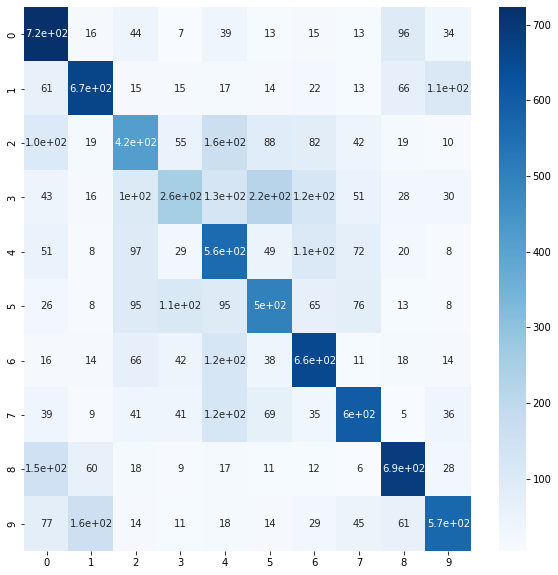

In [47]:
cf= confusion_matrix(test_labels, predicted_classes)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cf, annot=True, cmap='Blues', ax=ax)

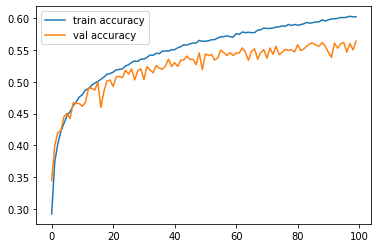

In [48]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

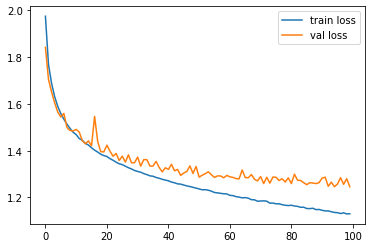

In [49]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Comment
### Model uzyskał niską dokładność na poziome  56%. Metryka accuracy wskazuje na to, że model często popełnia błędy w klasyfikacji zwłaszcza dla klas 2,3 i 5. Możliwe że przyuczenie modelu dla większej liczby epok pozwoliłoby na uzyskanie lepszego wyniku. We procesie uczenia nastąpiło zjawisko overfittingu, utrata dla zbioru uczącego jest dużo niższa niż dla zbioru walidacyjnego. Zastosowanie augumentacji danych uczących mogłoby pomóc zmiejszyć zjawisko overfittingu

# Classification corrected -> finding best model

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
assert train_images.shape == (50000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)
assert train_labels.shape == (50000, 1)
assert test_labels.shape == (10000, 1)

In [3]:
x_train = train_images.astype('float32') / 255.
x_test = test_images.astype('float32') / 255.
y_train = keras.utils.to_categorical(train_labels, 10)
y_test = keras.utils.to_categorical(test_labels, 10)

In [4]:
datagen = ImageDataGenerator(
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, )
datagen.fit(x_train)

In [5]:
dim_num_filters = Integer(low=4, high=128, name='num_filters')
dim_num_layers  =  Integer(low=1, high=5, name='num_layers')

dim_num_dense_nodes = Integer(low=256, high=3000, name='num_dense_nodes')
dim_num_dense_layers  =  Integer(low=1, high=5, name='num_dense_layers')

dim_activation = Categorical(categories=['sigmoid', 'tanh', 'softplus', 'softmax', 'relu'],
                             name='activation')
dim_dropout = Real(low=0.01, high=0.4, name='dropout')
dim_init = Categorical(
    categories=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal',
                'he_uniform'], name='kernel_initializer')
dim_optimizer = Categorical(categories=['RMSprop', 'Adam',  'Nadam', 'Adamax', 'SGD'], name='optimizer')
dim_loss = Categorical(categories=['categorical_crossentropy', 'categorical_hinge', 'mean_squared_error', 'huber_loss'],
                       name='loss')


In [6]:
dimensions = [dim_num_filters,
              dim_num_layers,
              dim_num_dense_nodes,
              dim_num_dense_layers,
              dim_activation,
              dim_dropout,
              dim_init,
              dim_optimizer,
              dim_loss]

In [7]:
default_parameters = [
 32,
 2, 
 1024,
 2,
 'relu',
 0.05,
 'he_normal',
 'Adam',
 'categorical_crossentropy']

In [8]:
def create_model( num_filters, num_layers, num_dense_nodes, num_dense_layers, activation, dropout, kernel_initializer, optimizer, loss):
    model = models.Sequential()
    model.add(Input(shape= (32,32,3)))
    for i in range(num_layers):
        model.add(Conv2D(num_filters, (3,3), padding="same", strides = 1, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i + 1)
        model.add(Dense(num_dense_nodes,
                        kernel_initializer=kernel_initializer,
                        activation=activation,
                        name=name))
        num_dense_nodes = num_dense_nodes // 2
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss=loss, optimizer=get_optimizer(optimizer), metrics=['accuracy'])
    return model

In [9]:
def get_optimizer(opt):
    if opt == 'RMSprop':
        optimizer = RMSprop(learning_rate=0.001)
    if opt == 'Adam':
        optimizer = Adam(learning_rate=0.001)
    if opt == 'SGD':
        optimizer = SGD(learning_rate=0.001)
    if opt == 'Nadam':
        optimizer = Nadam()
    if opt == 'Adamax':
        optimizer = Adamax(learning_rate=0.001)
    return optimizer

In [10]:
best_accuracy = 0.0
@use_named_args(dimensions=dimensions)
def fitness(num_filters, num_layers, num_dense_nodes, num_dense_layers, activation, dropout, kernel_initializer, optimizer, loss):
    # Print the hyper-parameters.
    print('num_filters:', num_filters)
    print('num_layers', num_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('num_dense_layers', num_dense_layers)
    print('activation:', activation)
    print('dropout:', dropout)
    print('kernel_initializer', kernel_initializer)
    print('optimizer:', optimizer)
    print('loss:', loss)
    print()
    tf.random.set_seed(3)
    model = create_model(num_filters = num_filters , num_layers= num_layers,
                        num_dense_nodes=num_dense_nodes,
                         num_dense_layers=num_dense_layers,
                         activation=activation,
                         dropout=dropout,
                         kernel_initializer=kernel_initializer,
                         optimizer=optimizer,
                         loss=loss)


    es = EarlyStopping(monitor='val_loss', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=True)
    es_acc = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, min_delta=0.00001, verbose=1, restore_best_weights=True)
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=1024),
                                  epochs=100,
                                  shuffle=True,
                                  validation_data = (x_test, y_test),
                                  callbacks=[es, es_acc])

    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy

    del model
    gc.collect()
    keras.backend.clear_session()
    return -accuracy

In [11]:
checkpoint_saver = CheckpointSaver("./checkpoint.pkl", compress=9)

In [ ]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=40,
                            x0=default_parameters, verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
num_filters: 32
num_layers 2
num_dense_nodes: 1024
num_dense_layers 2
activation: relu
dropout: 0.05
kernel_initializer he_normal
optimizer: Adam
loss: categorical_crossentropy



C:\Users\Weronika Gramacka\AppData\Local\Temp\ipykernel_58400\2278848102.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=1024),


Epoch 1/100
49/49 [==============================] - 42s 436ms/step - loss: 1.7139 - accuracy: 0.4096 - val_loss: 2.1578 - val_accuracy: 0.1293
Epoch 2/100
49/49 [==============================] - 21s 401ms/step - loss: 1.3007 - accuracy: 0.5391 - val_loss: 1.8703 - val_accuracy: 0.2915
Epoch 3/100
26/49 [==============>...............] - ETA: 7s - loss: 1.1688 - accuracy: 0.5871

In [ ]:
 search_result.x

In [ ]:
result = search_result.x
keras.backend.clear_session()
model = create_model(result[0], result[1], result[2], result[3], result[4], result[5],  result[6], result[7], result[8])
es = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.0001, verbose=1, restore_best_weights=True)
es_acc = EarlyStopping(monitor='val_accuracy', mode='max', patience=25, min_delta=0.00001, verbose=1, restore_best_weights=True)
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=1024),
                              epochs=200,
                              shuffle=True,
                              validation_data = (x_test, y_test),
                              callbacks=[es, es_acc])

In [ ]:
import numpy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
predictions = model.predict(x_test)
predicted_classes = numpy.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes)
print(report)

In [ ]:
cf= confusion_matrix(test_labels, predicted_classes)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cf, annot=True, cmap='Blues', ax=ax)
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Comment
### Dokładność na zbiorze trenującym -> 82%
### Dokładność na zbiorze testowym -> 62 %
### W procesie uczenia wystąpiło zjawisko overfittingu 